In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import metrics

## Load the dataset

In [2]:
# loading the dataset
data = pd.read_csv('credit_risk_dataset.csv')
print(data.shape)

(32581, 12)


## Standard Cleaning

- remove odd data (e.g., age > 120 years, employment history length > age + 15 years)
- drop duplicates
- replace ordinal categorical variables or binary nominal variables with discrete numerical variables

In [3]:
# drop outlier and unreasonable data
data = data[(data['person_emp_length'].isnull()) | (data['person_age'] >= 15+data['person_emp_length'])]
data = data[data['person_age']<100]

# drop duplicates
data = data.drop_duplicates()

# replace strings with integers
data['cb_person_default_on_file'].replace(['Y', 'N'], [1, 0], inplace = True)
data['loan_grade'].replace(['A', 'B', 'C', 'D', 'E', 'F', 'G'], [1, 2, 3, 4, 5, 6, 7], inplace = True)

## Check where the missing values come from

In [4]:
# Check for missing values
data.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3094
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

The missing values come from the interest rate and person employment length variables. Let's see if missing values from each variable have a higher rate of default.

In [5]:
# distribution of default and non-default loans among missing values (employment length)
data[data['person_emp_length'].isnull()]['loan_status'].value_counts()

loan_status
0    606
1    281
Name: count, dtype: int64

In [6]:
# distribution of default and non-default loans among missing values (interest rate)
data[data['loan_int_rate'].isnull()]['loan_status'].value_counts()

loan_status
0    2453
1     641
Name: count, dtype: int64

In [7]:
# distribution of default and non-default loans in the dataset
data['loan_status'].value_counts()

loan_status
0    25321
1     7088
Name: count, dtype: int64

The rate of default loans among the cases where the interest rate value is missing is very similar to the rate of default loans across the entire dataset (26% vs. 28%). On the other hand, the percentage of default loans among missing employment length values is much higher (40% vs. 28%).

## Employment length

Let's investigate how employment length relates to other variables.

In [8]:
# how employment length relates to other features
for col in data.columns:
    if data[col].dtype != 'object':
        print(col, ':', data['person_emp_length'].corr(data[col]))

person_age : 0.17248116147659007
person_income : 0.15441083823010934
person_emp_length : 1.0
loan_grade : -0.04931592638650811
loan_amnt : 0.1110864331965564
loan_int_rate : -0.058474495222758376
loan_status : -0.0863133770390054
loan_percent_income : -0.05846176792369783
cb_person_default_on_file : -0.03035352506658913
cb_person_cred_hist_length : 0.14961915667297732


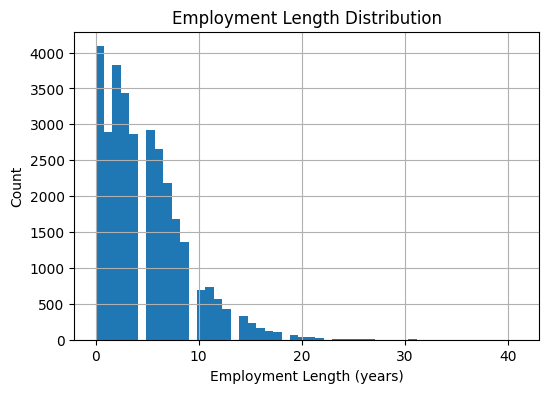

In [9]:
plt.figure(figsize=(6,4))
data['person_emp_length'].hist(bins=50)
plt.title('Employment Length Distribution')
plt.xlabel('Employment Length (years)')
plt.ylabel('Count')
plt.show()

### To drop or not to drop?

Create a simple (?) regression model to predict "person_emp_length" from other variables. This way, we will fill in the missing values with  predictions based on the rest of the data. We are doing this to avoid dropping the missing values.

In [10]:
# drop NA values to facilitate computations
data_noNA = data.dropna()

# select features: person_age, person_income, loan_amnt, cb_person_cred_hist_length
# X = data_noNA[['person_age', 'person_income', 'loan_amnt', 'cb_person_cred_hist_length']]
X = data_noNA[['person_age', 'person_income', 'loan_amnt', 'cb_person_cred_hist_length', 'loan_grade', 'cb_person_default_on_file', 'loan_percent_income', 'loan_int_rate']]
y = data_noNA['person_emp_length']

### Transformations

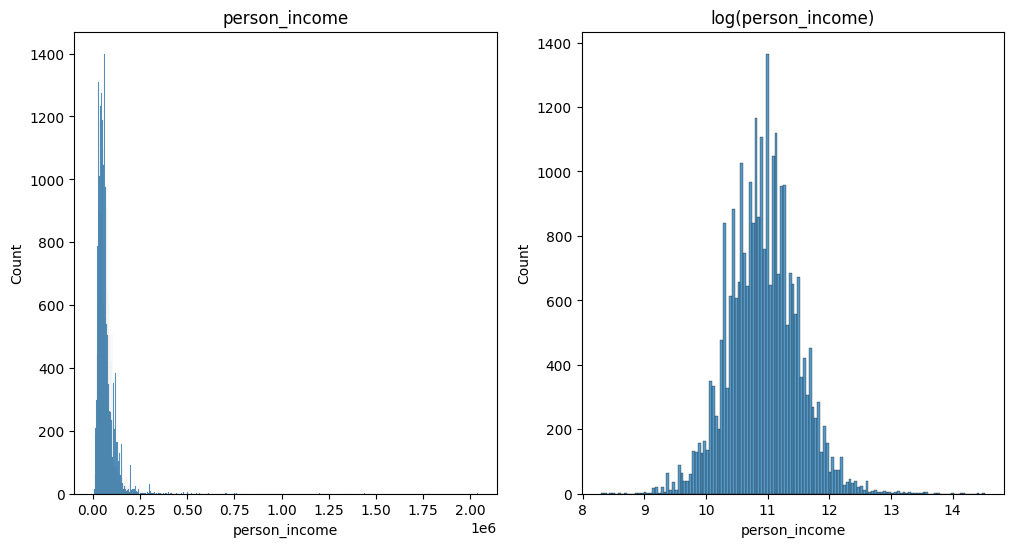

In [11]:
# plot person_income and log(person_income) to see the distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(X['person_income'])
plt.title('person_income')
plt.subplot(1, 2, 2)
sns.histplot(np.log(X['person_income']))
plt.title('log(person_income)')
plt.show()

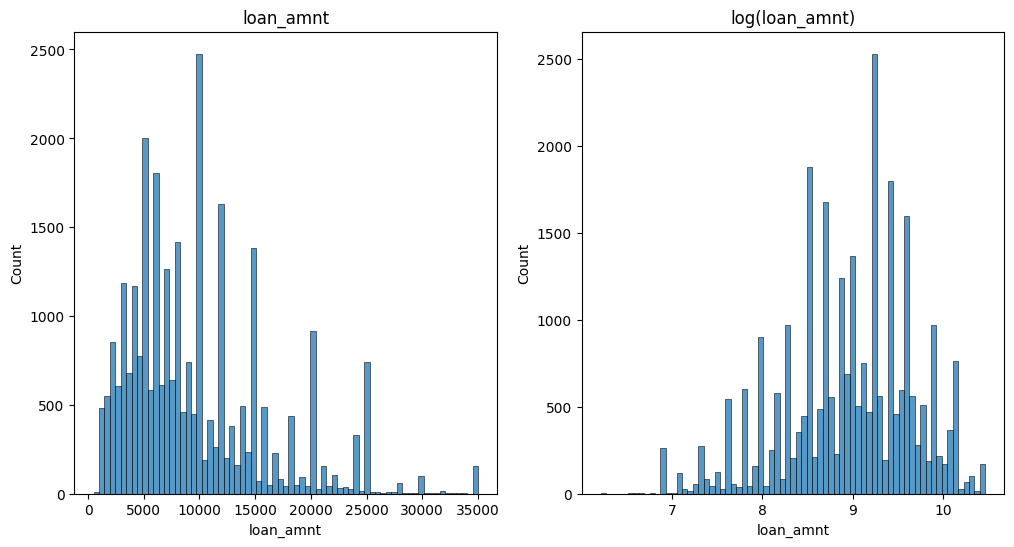

In [12]:
# same thing for loan amount
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(X['loan_amnt'])
plt.title('loan_amnt')
plt.subplot(1, 2, 2)
sns.histplot(np.log(X['loan_amnt']))
plt.title('log(loan_amnt)')
plt.show()

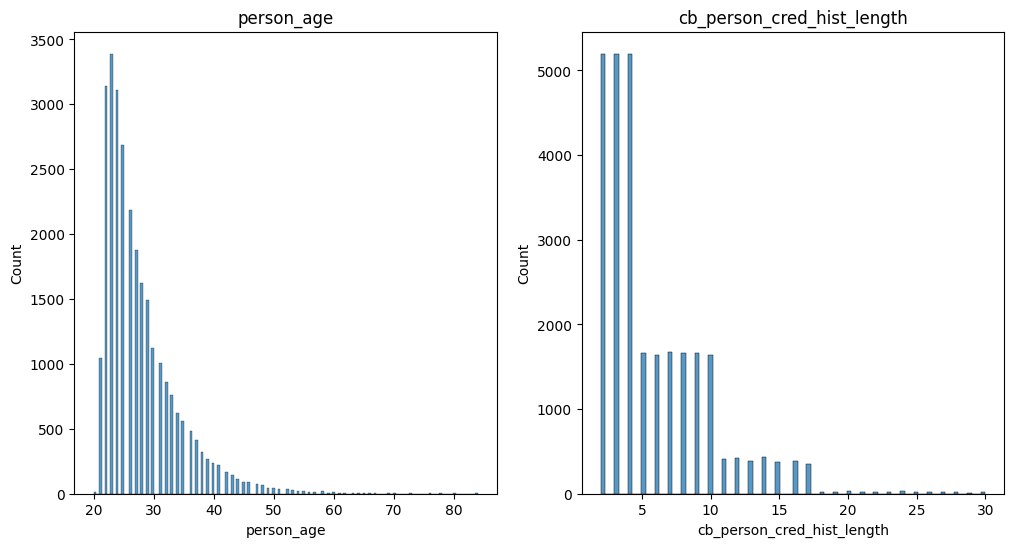

In [13]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(X['person_age'])
plt.title('person_age')
plt.subplot(1, 2, 2)
sns.histplot(X['cb_person_cred_hist_length'])
plt.title('cb_person_cred_hist_length')
plt.show()

In [14]:
X['person_income'] = np.log(X['person_income'])
X['loan_amnt'] = np.log(X['loan_amnt'])

/var/folders/f6/znb06gy13c5c28v99r1ds2fh0000gn/T/ipykernel_1985/2691995186.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['person_income'] = np.log(X['person_income'])
/var/folders/f6/znb06gy13c5c28v99r1ds2fh0000gn/T/ipykernel_1985/2691995186.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['loan_amnt'] = np.log(X['loan_amnt'])


In [15]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

We will try both a **linear regression** and a **random forest** model. The linear regression model led to very low coefficient of determination ($R^2<0.1$). On the other hand, the random forest reached an $R^2=0.1$ when applied on the testing dataset with an overfitted model.

In [16]:
# train a random forest regressor
regressor = RandomForestRegressor(
    n_estimators=100,
    #max_depth=10,                # limit depth
    #min_samples_leaf=5,          # ensure leaf nodes have at least 5 samples
    #max_features='sqrt',         # or 'auto' / 'log2'
    random_state=42
)
regressor.fit(X_train, y_train)

# predict the test set results
y_pred = regressor.predict(X_test)

In [17]:
# # train a linear regression model
# regressor = LinearRegression()
# regressor.fit(X_train, y_train)

# # predict the test set results
# y_pred = regressor.predict(X_test)

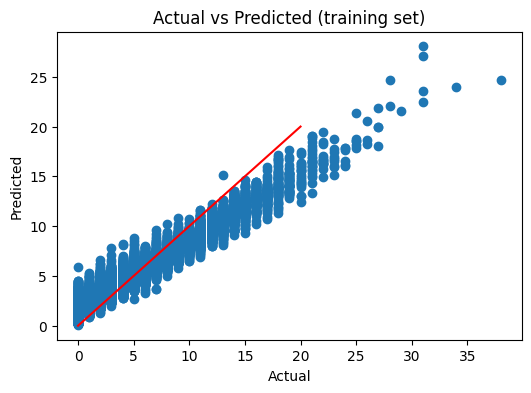

In [18]:
# scatter plot of the actual and predicted values
plt.figure(figsize=(6,4))
plt.scatter(y_train, regressor.predict(X_train))
plt.plot([0, 20], [0, 20], color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (training set)')
plt.show()

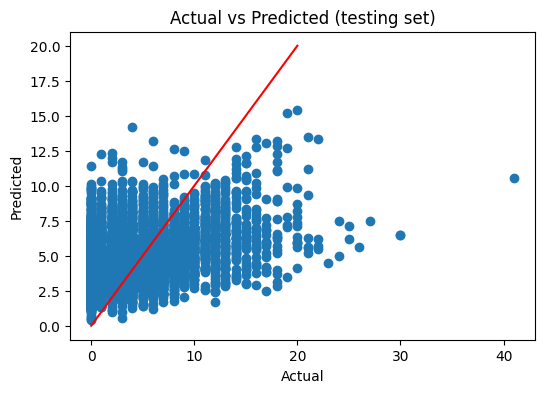

In [19]:
# scatter plot of the actual and predicted values
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred)
plt.plot([0, 20], [0, 20], color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (testing set)')
plt.show()

In [20]:
# evaluate the model
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 Score:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 2.9920816559296117
Mean Squared Error: 14.902702458862876
Root Mean Squared Error: 3.86040185199195
R2 Score: 0.1032588230895215


Because none of these models are good enough, we will resort to filling the missing employment length values with the median.

In [21]:
# replace the missing values in the original dataset with the median
data['person_emp_length'].fillna(data['person_emp_length'].median(), inplace = True)

## Interest Rate

In [22]:
# how interest rate relates to other features
for col in data.columns:
    if data[col].dtype != 'object':
        print(col, ':', data['loan_int_rate'].corr(data[col]))

person_age : 0.011129155000939464
person_income : -0.0010193389984226205
person_emp_length : -0.05577137626255824
loan_grade : 0.9337158355918536
loan_amnt : 0.14692640487573078
loan_int_rate : 0.9999999999999999
loan_status : 0.33581219483649066
loan_percent_income : 0.12011106741459722
cb_person_default_on_file : 0.5009599879472479
cb_person_cred_hist_length : 0.01585538877327745


In [23]:
# drop NA values to facilitate computations
data_noNA = data.dropna()

X = data_noNA[['person_age', 'person_income', 'loan_amnt', 'cb_person_cred_hist_length', 'loan_grade', 'cb_person_default_on_file', 'loan_percent_income']]
X['person_income'] = np.log(X['person_income'])
X['loan_amnt'] = np.log(X['loan_amnt'])
y = data_noNA['loan_int_rate']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 34)

/var/folders/f6/znb06gy13c5c28v99r1ds2fh0000gn/T/ipykernel_1985/3755052124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['person_income'] = np.log(X['person_income'])
/var/folders/f6/znb06gy13c5c28v99r1ds2fh0000gn/T/ipykernel_1985/3755052124.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['loan_amnt'] = np.log(X['loan_amnt'])


In [24]:
# train a linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# predict the test set results
y_pred = regressor.predict(X_test)

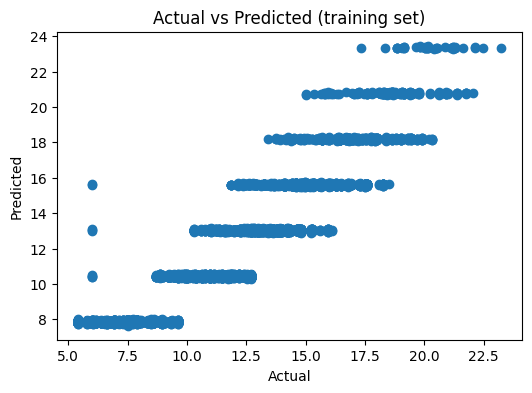

In [25]:
# scatter plot of the actual and predicted values
plt.figure(figsize=(6,4))
plt.scatter(y_train, regressor.predict(X_train))
# plt.plot([0, 20], [0, 20], color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (training set)')
plt.show()

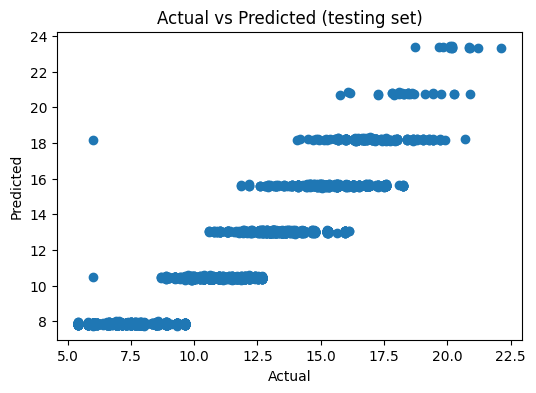

In [26]:
# scatter plot of the actual and predicted values
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred)
# plt.plot([0, 20], [0, 20], color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (testing set)')
plt.show()

In [27]:
# evaluate the model
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 Score:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 0.9180766898868669
Mean Squared Error: 1.3730770780204091
Root Mean Squared Error: 1.171783716400091
R2 Score: 0.8693984843330945


In [28]:
print(regressor.coef_)

[-7.42918721e-03 -1.84960581e-02 -1.01375807e-02  1.24696209e-02
  2.58314165e+00 -3.32273290e-05  1.86405109e-01]


As expected, `loan_grade` contributes the most to determining the interest rate; the next feature is `cb_person_default_on_file`. 

We fill in the interest rate values with the values we predict from the model.

In [29]:
data_NA = data[data['loan_int_rate'].isnull()]
data_NA_X = data_NA[['person_age', 'person_income', 'loan_amnt', 'cb_person_cred_hist_length', 'loan_grade', 'cb_person_default_on_file', 'loan_percent_income', 'loan_int_rate']]
data_NA_X['person_income'] = np.log(data_NA_X['person_income'])
data_NA_X['loan_amnt'] = np.log(data_NA_X['loan_amnt'])

data_NA_X['loan_int_rate'] = regressor.predict(data_NA_X[['person_age', 'person_income', 'loan_amnt', 'cb_person_cred_hist_length', 'loan_grade', 'cb_person_default_on_file', 'loan_percent_income']])

data.update(data_NA_X)

/var/folders/f6/znb06gy13c5c28v99r1ds2fh0000gn/T/ipykernel_1985/2933320446.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_NA_X['person_income'] = np.log(data_NA_X['person_income'])
/var/folders/f6/znb06gy13c5c28v99r1ds2fh0000gn/T/ipykernel_1985/2933320446.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_NA_X['loan_amnt'] = np.log(data_NA_X['loan_amnt'])
/var/folders/f6/znb06gy13c5c28v99r1ds2fh0000gn/T/ipykernel_1985/2933320446.py:6: SettingWithCopyWarning: 
A value is trying to be set on a

In [30]:
data.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [31]:
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,21,9600.0,OWN,5.0,EDUCATION,2,1000.0,11.14,0,0.10,0,2
2,25,9600.0,MORTGAGE,1.0,MEDICAL,3,5500.0,12.87,1,0.57,0,3
3,23,65500.0,RENT,4.0,MEDICAL,3,35000.0,15.23,1,0.53,0,2
4,24,54400.0,RENT,8.0,MEDICAL,3,35000.0,14.27,1,0.55,1,4
5,21,9900.0,OWN,2.0,VENTURE,1,2500.0,7.14,1,0.25,0,2
